### 1. Introduction/Business Problem

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an Chinese restaurant in Warsaw, Poland.


Since there are lots of restaurants in Warsaw we will try to detect locations that are not already crowded with restaurants. We are also particularly interested in areas with no Italian restaurants in vicinity. We would also prefer locations as close to city center as possible, assuming that first two conditions are met.


### 2. Data 

To solve this problem, the data from:
* https://pl.wikipedia.org/wiki/Ludność_Warszawy showing how many inhabitants there are in each district and how this value has changed over 12 years, it will help identify promising regions 
* Data from foursquare to check whether there are already similar restaurants in the area 

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

import geopandas as gpd
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

import requests
from bs4 import BeautifulSoup
from tabulate import tabulate
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library
import matplotlib.pyplot as plt
%matplotlib inline

### Neighborhood Candidates

At the very beginning I chose 4 promising locations, 3 of which are on the right side of the Vistula, and one on the east.The first location is in the northern part of the city, in the Żoliborz district, the next point of reference is the Palace of Science Culture in the city centre. The third point is Służew, located in southern Moktów. The last point is the metro station on the right side of the Vistula River - Dworzec. 

In [2]:
address1 = 'plac Defilad 1, Warszawa, Polska'
address2 = 'Służew, Warszawa, Polska'
address3 = 'Marymont, Warszawa, Polska'
address4 = 'Dworzec Wileński, Warszawa, Polska'


def geolocalisation(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print(latitude, longitude)
    return latitude, longitude

geo_plac = geolocalisation(address1)
geo_sluzew = geolocalisation(address2)
geo_marymont = geolocalisation(address3)
geo_dworzec = geolocalisation(address4)

52.2317641 21.005799675616117
52.1727624 21.0262866
52.2716615 20.9717196
52.2540622 21.0355034


At the very beginning, I set the geographical coordinates of the previously indicated points.

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on chinese restaurants in each neighborhood. We create a list of objects that contains the word "Chinese"

In [3]:
CLIENT_ID = 'JS1NRA2OYUOT5A5320ZM0WVI0UB0AKFZXQLKFOTK5GCFTK11'
CLIENT_SECRET = 'OH54GJOCDQFF33CGKAH2UQWK1MZPQXQUQPDBWHFZUCV3HIFY'
VERSION = '20200601'
LIMIT = 200
search_query = 'chinese restaurant'
radius = 5000

The next step is to create a function that will make our task easier, using it, we will download data about restaurants near our points

In [4]:
def url_result(geo_loc):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, geo_loc[0], geo_loc[1], VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    venues = results['response']['venues']

    # tranform venues into a dataframe
    dataframe = json_normalize(venues)
    return dataframe

dfresults_plac = url_result(geo_plac)
dfresults_sluzew = url_result(geo_sluzew)
dfresults_marymont = url_result(geo_marymont)
dfresults_dworzec = url_result(geo_dworzec)
dfresults_plac.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d11f941735', 'name': 'N...",False,518afe0c498e0a7182bb9165,Zgoda 11,PL,NaN,Polska,NaN,433,"[Zgoda 11, Polska]","[{'label': 'display', 'lat': 52.23337554931640...",52.233376,21.011585,NaN,NaN,NaN,Night Club & Restaurant New Orleans,v-1591383351,NaN
1,"[{'id': '4f04af1f2fb6e1c99f3db0bb', 'name': 'T...",False,4bd81ca809ecb713810d487c,Nowogrodzka 47A,PL,Warszawa,Polska,Pankiewicza,492,"[Nowogrodzka 47A (Pankiewicza), 00-659 Warszaw...","[{'label': 'display', 'lat': 52.22770260648275...",52.227703,21.008666,NaN,00-659,Województwo mazowieckie,Lokanta,v-1591383351,NaN
2,"[{'id': '4bf58dd8d48988d198941735', 'name': 'C...",False,4f4d01a3e4b0272872302a95,Świętokrzyska 20A,PL,NaN,Polska,NaN,541,"[Świętokrzyska 20A, Polska]","[{'label': 'display', 'lat': 52.2355462139701,...",52.235546,21.010804,NaN,NaN,NaN,Haopengyou Chinese School,v-1591383351,NaN
3,"[{'id': '4bf58dd8d48988d142941735', 'name': 'A...",False,5072cf9de4b09145cdefc0c1,Emilii Plater 47,PL,Warszawa,Polska,Złotej,194,"[Emilii Plater 47 (Złotej), Warszawa, Polska]","[{'label': 'display', 'lat': 52.23111917853823...",52.231119,21.003150,NaN,NaN,Województwo mazowieckie,AP Foods Orient Asian Restaurant,v-1591383351,NaN
4,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",False,5008648ee4b05525ca864aef,Emilii Plater 49,PL,Warszawa,Polska,NaN,206,"[Emilii Plater 49, 00-125 Warszawa, Polska]","[{'label': 'display', 'lat': 52.23244212951155...",52.232442,21.002988,NaN,00-125,Województwo mazowieckie,Platter by Karol Okrasa,v-1591383351,NaN


In [5]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 3. Data cleaning 

The data we have downloaded is unordered, so now we are creating a function that will prepare the data for further analysis. 

In [6]:
def filtered(dataframe):
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]
    
    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
                                       
    return dataframe_filtered


dffiltered_plac = filtered(dfresults_plac)
dffiltered_sluzew = filtered(dfresults_sluzew)
dffiltered_marymont = filtered(dfresults_marymont)
dffiltered_dworzec = filtered(dfresults_dworzec)

### 4. Data visualisation 

Now that our data is in order, we can present it graphically. We create a function that will display a city map with restaurants and our locations 

In [7]:
def map_of_restaurant(latitude, longitude, dataframe_filtered, address):
    venues_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around Pałac kultury i nauki


    # add a red circle marker to represent Pałac kultury i nauki 
    folium.features.CircleMarker(
        [latitude, longitude],
        radius=10,
        color='red',
        popup=address,
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.6
    ).add_to(venues_map)

    # add the Chinese restaurants as orange circle markers
    for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color='orange',
            popup=label,
            fill = True,
            fill_color='orange',
            fill_opacity=0.6
        ).add_to(venues_map)
        
    
    return venues_map



plac Defilad 1, Warsaw, Poland

In [8]:
map_of_restaurant(geo_plac[0], geo_plac[1], dffiltered_plac,address1)

Służew, Warsaw, Poland

In [9]:
map_of_restaurant(geo_sluzew[0], geo_sluzew[1], dffiltered_sluzew, address2)

Marymont, Warsaw, Poland

In [10]:
map_of_restaurant(geo_marymont[0], geo_marymont[1], dffiltered_marymont, address3)

Dworzec Wileński, Warsaw, Poland

In [11]:
map_of_restaurant(geo_dworzec[0], geo_dworzec[1], dffiltered_dworzec, address4)

### Methodology 
In this project we will direct our efforts on detecting areas of Warsaw that have low restaurant density, particularly those with low number of Chinese restaurants. 
In first step we have collected the required data: location and identify Chinese restaurants (according to Foursquare categorization).
In the second part, we will be subject to demographic change. We will examine which places are the most populated, which have a tendency to increase in population, and which are the opposite.

### Analysis 
The analysis will be based on demographic data 

In [12]:
res = requests.get("https://pl.wikipedia.org/wiki/Ludność_Warszawy")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
warsaw_df = df[0]
warsaw_df = warsaw_df[['dzielnica','2005 ogółem', '2017 ogółem']]
warsaw_df.rename(columns={'dzielnica':'neighborhood', '2005 ogółem':'population_in_2005', '2017 ogółem':'population_in_2017'}, inplace=True)
warsaw_df['%_change'] = ((warsaw_df['population_in_2017'] - warsaw_df['population_in_2005'])/warsaw_df['population_in_2005']) * 100

/Users/dominiksadzik/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/dominiksadzik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
names = warsaw_df['neighborhood'].to_list()
names

['Bemowo',
 'Białołęka',
 'Bielany',
 'Mokotów',
 'Ochota',
 'Praga-Południe',
 'Praga-Północ',
 'Rembertów',
 'Śródmieście',
 'Targówek',
 'Ursus',
 'Ursynów',
 'Wawer',
 'Wesoła',
 'Wilanów',
 'Włochy',
 'Wola',
 'Żoliborz']

Let's count the percentage changes of humanity in individual districts over 12 years and then present them with the bar chart. The largest population growth was recorded in Wilanów (southern part of Warsaw), followed by Białołęka (northern part of Warsaw). Both districts are located on the left side of the Vistula River 

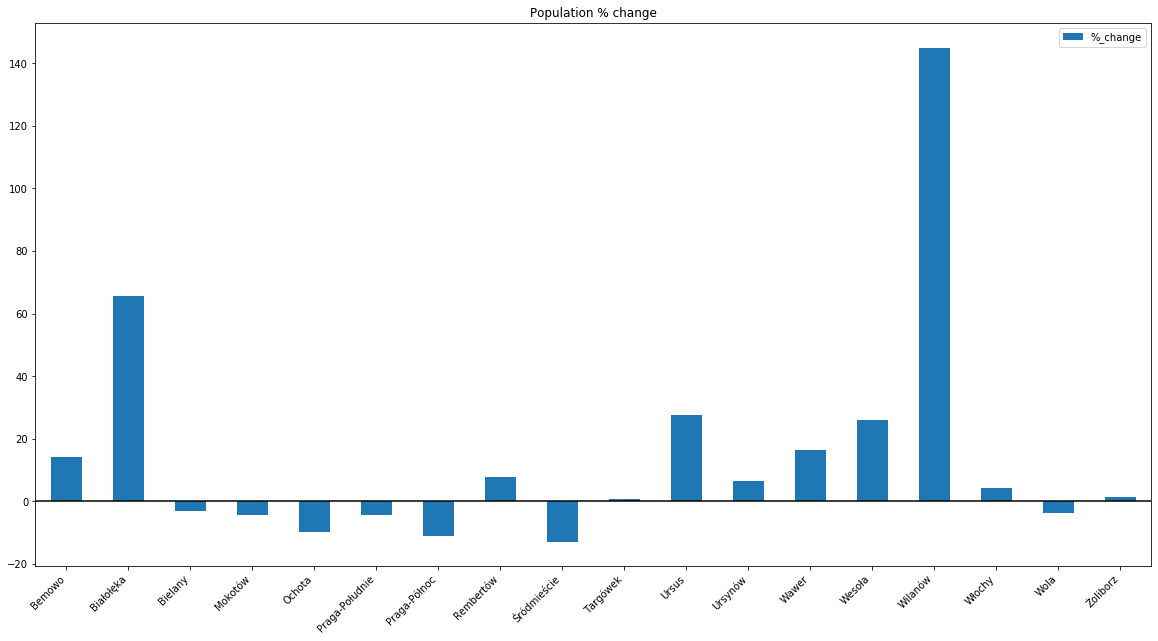

In [14]:
warsaw_df[['neighborhood', '%_change']].plot(kind='bar', figsize=(20, 10))
locs, labels=plt.xticks()
x_ticks = []
new_xticks=[names[d] for d in locs]
plt.xticks(locs,new_xticks, rotation=45, horizontalalignment='right')
plt.axhline(y=0, color='black')
plt.title('Population % change')
plt.show()

Despite a slight decrease, Mokotow has the largest population. From the above data one can observe a certain trend. The central districts of the city are depopulated in favour of those on the outskirts.

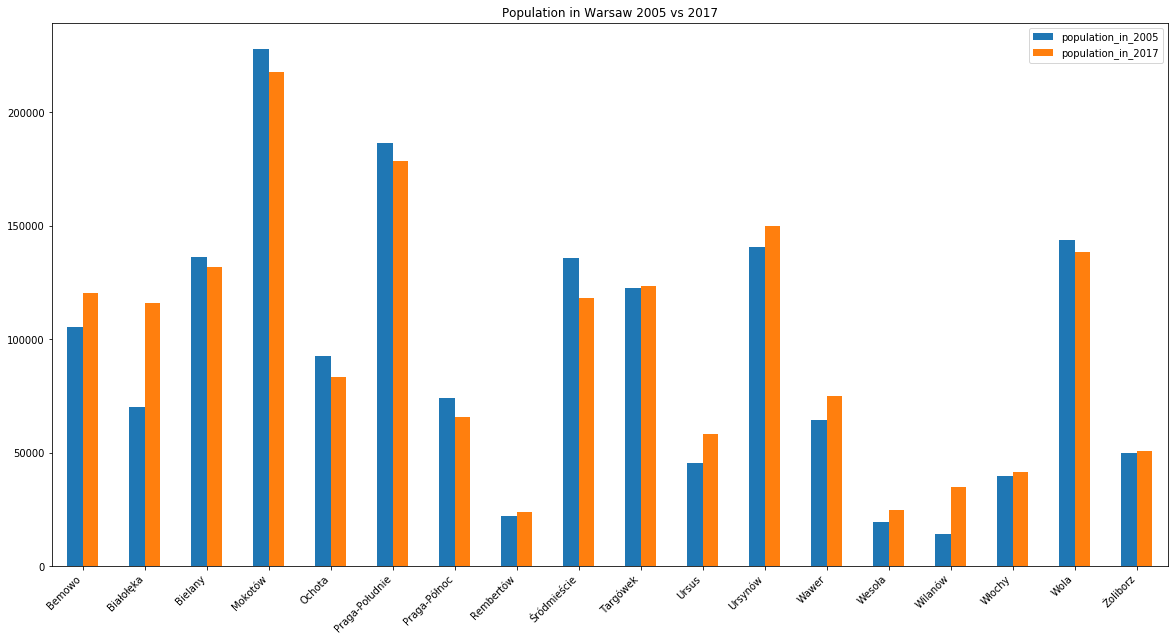

In [15]:
warsaw_df[['neighborhood', 'population_in_2005', 'population_in_2017']].plot(kind='bar', figsize=(20, 10))
locs, labels=plt.xticks()
x_ticks = []
new_xticks=[names[d] for d in locs]
plt.xticks(locs,new_xticks, rotation=45, horizontalalignment='right')
plt.title('Population in Warsaw 2005 vs 2017')
plt.show()

In [16]:
waw_geo = gpd.read_file('warszawa_dzielnice.geojson')
print(waw_geo.head())

   cartodb_id       name                                           geometry
0           1   Warszawa  MULTIPOLYGON (((21.02753 52.36513, 21.02539 52...
1          22     Ochota  MULTIPOLYGON (((21.00152 52.22807, 20.99059 52...
2          25  Rembertów  MULTIPOLYGON (((21.13242 52.23909, 21.13313 52...
3           2     Bemowo  MULTIPOLYGON (((20.87309 52.21666, 20.87307 52...
4          19  Białołęka  MULTIPOLYGON (((20.99622 52.28734, 20.99782 52...


At the very end, let's show you what the restaurants we're investigating look like against the background of the whole city 

In [17]:
All = pd.concat([dffiltered_plac, dffiltered_sluzew, dffiltered_marymont, dffiltered_marymont])

def restaurants(path, latitude, longitude, dataframe_filtered ,address):
    venues_map = folium.Map(location=[latitude, longitude], zoom_start=12)
    
    venues_map.choropleth(
        geo_data=path,
        key_on='feature.properties.DISTRICT',
        fill_color='YlOrRd'
        )
    
    
    folium.features.CircleMarker(
        [latitude, longitude],
        radius=10,
        color='red',
        popup=address,
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.6
    ).add_to(venues_map)

    # add the Chinese restaurants as orange circle markers
    for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color='orange',
            popup=label,
            fill = True,
            fill_color='orange',
            fill_opacity=0.6
        ).add_to(venues_map)
    
    return venues_map
    
restaurants(waw_geo, geo_plac[0], geo_plac[1],All ,address1)

### Results and Discussion 

According to our analysis, there are many Chinese restaurants in Warsaw, most of which are located in the central part of the city. There are also a lot of restaurants in the south (Mokotów and Wilanów). The best place to set up a restaurant seems to be in the north of Żoliborz, as its population is slowly growing, moreover, neighboring Białołęka is growing very fast. The establishment of a restaurant in such a place could be an attraction for the residents. They would not have to go to the centre to eat Chinese food. 


### Conclusion 
Purpose of this project was to identify Warsaw areas close to center with low number of restaurants (particularly Chinese restaurants) in order to aid stakeholders in narrowing down the search for optimal location for a new Italian restaurant. 

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.